In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error

In [2]:
def load_dataset(
    start_date: str = '1999-12-31',
    end_date: str = '2019-01-01') -> np.ndarray:
    '''
    Parameters
    ----------
    start_date: str, start date of the stock dataset, default = '1999-12-31'
    end_date: str, end date of the stock dataset, default = '2019-01-01'
    
    Returns
    -------
    np.ndarray
    '''
    data_raw = pd.read_csv('data_ml.csv', index_col=0)
    data_raw.reset_index(inplace=True)
    del data_raw['index']

    idx_date = data_raw.index[(data_raw['date'] > start_date) & (data_raw['date'] < end_date)].to_list()
    data_ml = data_raw.iloc[idx_date]
    
    return data_ml

In [3]:
data_ml = load_dataset()

In [4]:
features = data_ml.columns[2:95]
print(features)

Index(['Advt_12M_Usd', 'Advt_3M_Usd', 'Advt_6M_Usd', 'Asset_Turnover',
       'Bb_Yld', 'Bv', 'Capex_Ps_Cf', 'Capex_Sales', 'Cash_Div_Cf',
       'Cash_Per_Share', 'Cf_Sales', 'Debtequity', 'Div_Yld', 'Dps', 'Ebit_Bv',
       'Ebit_Noa', 'Ebit_Oa', 'Ebit_Ta', 'Ebitda_Margin', 'Eps', 'Eps_Basic',
       'Eps_Basic_Gr', 'Eps_Contin_Oper', 'Eps_Dil', 'Ev', 'Ev_Ebitda',
       'Fa_Ci', 'Fcf', 'Fcf_Bv', 'Fcf_Ce', 'Fcf_Margin', 'Fcf_Noa', 'Fcf_Oa',
       'Fcf_Ta', 'Fcf_Tbv', 'Fcf_Toa', 'Fcf_Yld', 'Free_Ps_Cf', 'Int_Rev',
       'Interest_Expense', 'Mkt_Cap_12M_Usd', 'Mkt_Cap_3M_Usd',
       'Mkt_Cap_6M_Usd', 'Mom_11M_Usd', 'Mom_5M_Usd', 'Mom_Sharp_11M_Usd',
       'Mom_Sharp_5M_Usd', 'Nd_Ebitda', 'Net_Debt', 'Net_Debt_Cf',
       'Net_Margin', 'Netdebtyield', 'Ni', 'Ni_Avail_Margin', 'Ni_Oa',
       'Ni_Toa', 'Noa', 'Oa', 'Ocf', 'Ocf_Bv', 'Ocf_Ce', 'Ocf_Margin',
       'Ocf_Noa', 'Ocf_Oa', 'Ocf_Ta', 'Ocf_Tbv', 'Ocf_Toa', 'Op_Margin',
       'Op_Prt_Margin', 'Oper_Ps_Net_Cf', 'Pb', 'Pe', 'Pt

In [5]:
df_median = []
df = []
df_median = data_ml[['date', 'R1M_Usd', 'R12M_Usd']].groupby(['date']).median()
df_median.rename(columns={'R1M_Usd': 'R1M_Usd_median', 'R12M_Usd': 'R12M_Usd_median'}, inplace=True)
df = pd.merge(data_ml, df_median, how='left', on=['date'])
data_ml['R1M_Usd_C'] = np.where(df['R1M_Usd'] > df['R1M_Usd_median'], 1, 0)
data_ml['R12M_Usd_C'] = np.where(df['R12M_Usd'] > df['R12M_Usd_median'], 1, 0)

In [6]:
X = data_ml[features]
y = data_ml['R1M_Usd']
y_c = data_ml['R1M_Usd_C']

In [7]:
separation_date = '2014-01-15'
idx_train = data_ml.index[(data_ml['date'] < separation_date)].to_list()
idx_test = data_ml.index[(data_ml['date'] >= separation_date)].to_list()
training_sample = data_ml.loc[idx_train]
testing_sample = data_ml.loc[idx_test]

In [8]:
fit_tree = tree.DecisionTreeRegressor(
    min_samples_split=8000,
    max_depth=3,
    ccp_alpha=0.000001,
    min_samples_leaf=3500
)
fit_tree.fit(X, y)

DecisionTreeRegressor(ccp_alpha=1e-06, max_depth=3, min_samples_leaf=3500,
                      min_samples_split=8000)

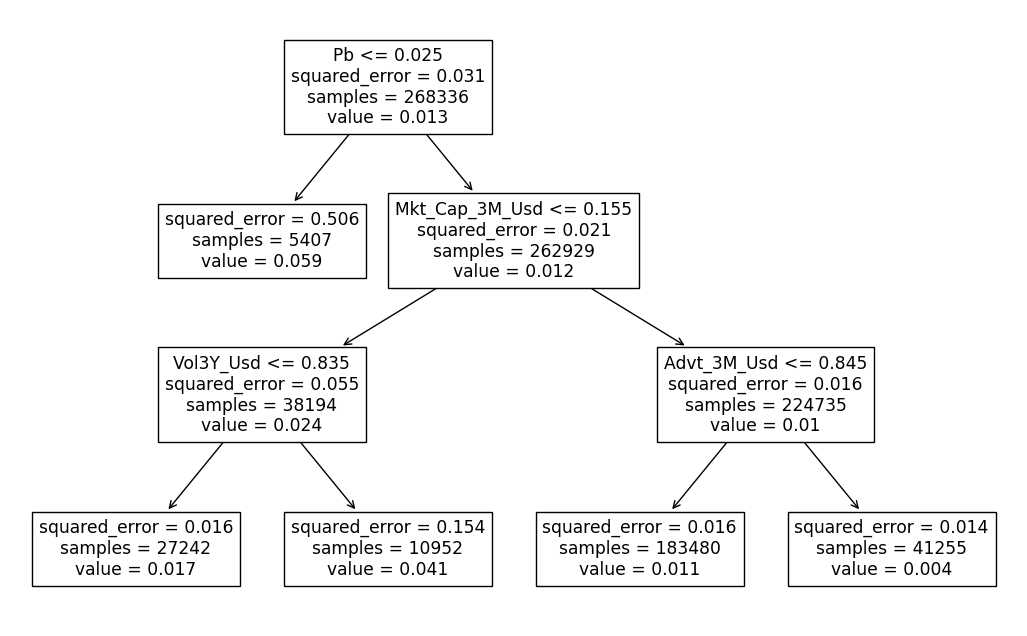

In [9]:
fig, ax = plt.subplots(figsize=(13, 8))
tree.plot_tree(fit_tree, feature_names=X.columns.values, ax=ax)
plt.show()

In [10]:
y_pred = fit_tree.predict(X.iloc[0:6,])
print(f'y_pred: {y_pred}')

y_pred: [0.01088066 0.01088066 0.01088066 0.01088066 0.04133053 0.04133053]


In [11]:
y_train = training_sample['R1M_Usd']
y_c_train = training_sample['R1M_Usd_C']
X_train = training_sample[features]
y_test = testing_sample['R1M_Usd']
y_c_test = testing_sample['R1M_Usd_C']
X_test = testing_sample[features]

fit_tree2 = tree.DecisionTreeRegressor(
    min_samples_split=4000,
    max_depth=5,
    ccp_alpha=0.0001,
    min_samples_leaf=1500
)
fit_tree2.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0001, max_depth=5, min_samples_leaf=1500,
                      min_samples_split=4000)

In [12]:
mse = np.mean((fit_tree2.predict(X_test) - y_test)**2)
print(f'MSE: {mse}')

MSE: 0.036996958091850045


In [13]:
hitratio = np.mean(fit_tree2.predict(X_test)*y_test > 0)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.5460346399270738


In [14]:
fit_RF = RandomForestRegressor(
    n_estimators = 40,
    criterion = 'squared_error',
    min_samples_split = 250,
    bootstrap = True,
    max_features = 30,
    max_samples = 10000,
)
fit_RF.fit(X_train, y_train)

RandomForestRegressor(max_features=30, max_samples=10000, min_samples_split=250,
                      n_estimators=40)

In [15]:
fit_RF.predict(pd.DataFrame(X_test).iloc[0:5,])

array([0.09938399, 0.10152566, 0.09626466, 0.08232744, 0.10115017])

In [16]:
mse = mean_squared_error(y_test, fit_RF.predict(X_test))
print(f'MSE: {mse}')

MSE: 0.03697049848911088


In [17]:
hitratio = np.mean(fit_RF.predict(X_test)*y_test > 0)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.5377449863263446


In [18]:
fit_RF_C = RandomForestClassifier(
    n_estimators = 40,
    criterion = 'gini',
    min_samples_split = 250,
    bootstrap = True,
    max_features = 30,
    max_samples = 10000,
)
fit_RF_C.fit(X_train, y_c_train)

RandomForestClassifier(max_features=30, max_samples=10000,
                       min_samples_split=250, n_estimators=40)

In [19]:
hitratio = np.mean(fit_RF_C.predict(X_test) == y_c_test)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.4975074065633546
